## Подготовка данных

---

---

### Загрузим датасет, познакомимся с данными

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

**Загрузим датасет:**

In [2]:
try:
    df = pd.read_csv('/content/autos.csv')
except:
    df = pd.read_csv('/ds/content/autos.csv')

**Объявим константы:**

In [3]:
RS = 1234

---

**Посмотрим на данные:**

In [4]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

---

**Промежуточный вывод:**

**В датасете присутствуют данные таких типов:**
- object
- int64

**В некоторых колонка присутствуют пропуски**

**В названиях колонок есть нарушение стиля snake_case**

**В датасете 16 колонок, названия колонок такие:**

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)


---

---

### Названия колонок

---

**Скоректируем названия колонок в соответствии со стилем snake_case:**

In [6]:
df = df.rename(
    columns={
        'DateCrawled': 'date_crawled',
        'Price': 'price',
        'VehicleType': 'vehicle_type',
        'RegistrationYear': 'registration_year',
        'Gearbox': 'gearbox',
        'Power': 'power',
        'Model': 'model',
        'Kilometer': 'kilometer',
        'RegistrationMonth': 'registration_month',
        'FuelType': 'fuel_type',
        'Brand': 'brand',
        'Repaired': 'repaired',
        'DateCreated': 'date_created',
        'NumberOfPictures': 'number_of_pictures',
        'PostalCode': 'postal_code',
        'LastSeen': 'last_seen'
    })

In [7]:
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


---

---

### Неинформативные признаки

---

**Мы знаем, что для заказчика важно `высокое качество`, `быстрое обучение` и `предсказания модели`, а также знаем, что модель будет работать в дальнейшем всегда на `будующих объявлениях`.**

**Что бы повысить эти показатели, удалим `неинформативные признаки`, такие как `date_crawled`, `date_created`, `postal_code`, `number_of_pictures`, `last_seen`.**

In [8]:
df = df.drop(columns=['date_crawled', 'postal_code', 'number_of_pictures', 'last_seen'], axis=1)

**Проверим результат:**

In [9]:
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00


---

---

### Обработка пропусков

---

**Посмотрим на колличество пропусков в процентном соотношении:**

In [10]:
df.isna().mean() * 100

price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
repaired              20.079070
date_created           0.000000
dtype: float64

---

**Промежуточный вывод:**

**Видим, что пропуски присутствуют в колонках `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`.**

**Отметим, что больше всего пропусков в колонке `repaired`, информация в ней - была ли машина в ремонте или нет.**

---

---

**Пропуски в колонке `vehicle_type`, он же тип кузова машины, заполнить по другим колонкам с высокой точностью не получится, поэтому удалим пропуски в этой колонке:**

In [12]:
df = df.loc[~df['vehicle_type'].isna()]

---

---

**Пропуски в столбце `model` заполнить с высокой точностью не получится, поэтому удалим пропуски в этой колонке:**

In [13]:
df = df.loc[~df['model'].isna()]

---

---

**Пропуски в колонке `gearbox`, тип коробка передач, можно заполнить самым часто встречающимся значением (модой) по конкретной модели автомобиля в строке с пропуском:**

In [14]:
for m in df['model'].unique():
    df.loc[(df['model'] == m) & (df['gearbox'].isna()), 'gearbox'] = \
    (df.loc[df['model'] == m, 'gearbox'].mode())[0]

---

---

**Посмотрим на уникальные значения колонки `fuel_type`:**

In [15]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

**Petrol и gasoline на самом деле одно и то же, просто разные слова. Эти два слова имеют одинаковое значение, с той лишь разницей, что они используются в тех местах, где они используются. Термин «petrol» используется в Великобритании, Индии и некоторых других странах, тогда как «gasoline» или «gas» для краткости используется в Соединенных Штатах.**

**Заменим два названия одного и того же на одно - например `petrol`:**

In [16]:
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

**Пропуски в этой колонки заменим часто встречающимся значением по соответствующей моделе:**

In [17]:
for m in df['model'].unique():
    df.loc[(df['model'] == m) & (df['fuel_type'].isna()), 'fuel_type'] = \
    (df.loc[df['model'] == m, 'fuel_type'].mode())[0]

---

---

**Пропуски в колонке `repaired`, была ли машина в ремонте или нет, восстановить с высокой точностью без дополнительных данных не получится, заменим пропуски значением 'unknown'**

In [18]:
df['repaired'] = df['repaired'].fillna('unknown')

---

---

### Исследование целевой переменной

---

**Посмотрим на значения в колонке с целевой переменной:**

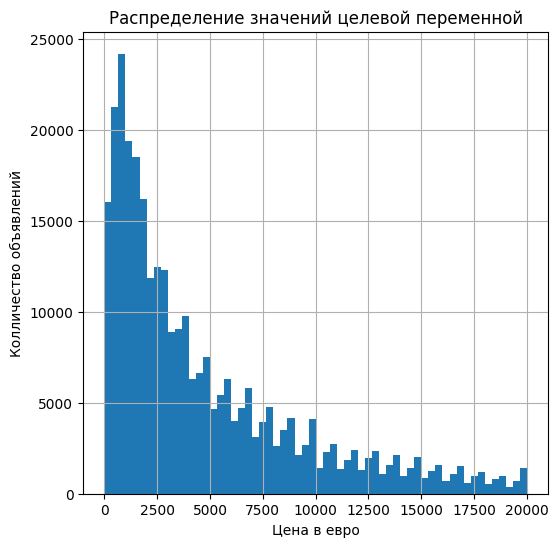

In [19]:
df['price'].hist(bins=60, figsize=[6,6])
plt.title('Распределение значений целевой переменной')
plt.xlabel('Цена в евро')
plt.ylabel('Колличество объявлений')
plt.show()

---

---

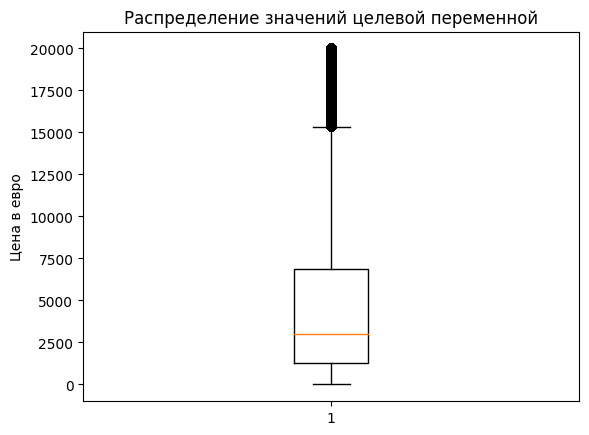

In [20]:
plt.boxplot(df['price'])
plt.title('Распределение значений целевой переменной')
plt.ylabel('Цена в евро')
plt.show()

**Видим, что есть нулевые значения цены продажи, такие данные не будут способствовать увеличению точности прогноза модели. Также цены в 20000 и несколько сотен евро могут существовать в теории как части автомобиля на продажу, в итоге удалим все что ниже 200 евро:**

In [21]:
df = df[df['price'] > 300]

---

---

### Исследование признаков

**Посмотрим на признак `power`, мощность:**

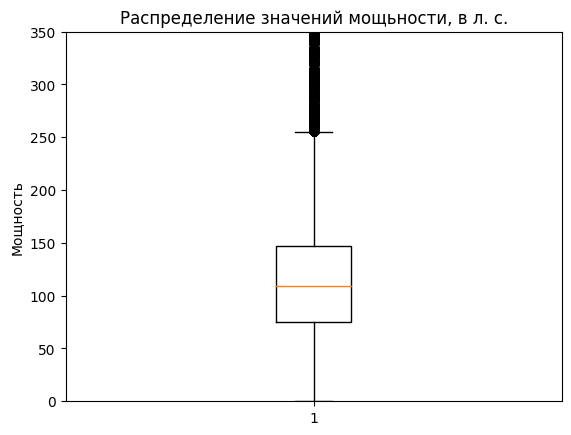

In [22]:
plt.boxplot(df['power'])
plt.title('Распределение значений мощьности, в л. с.')
plt.ylabel('Мощность')
plt.ylim(0,350)
plt.show()

---

In [23]:
df['power'].describe(percentiles=[0.05, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99])

count    288181.000000
mean        117.134693
std         178.966803
min           0.000000
5%            0.000000
10%          54.000000
15%          60.000000
20%          69.000000
25%          75.000000
50%         109.000000
75%         147.000000
80%         156.000000
85%         170.000000
90%         185.000000
95%         220.000000
97.5%       245.000000
99%         300.000000
max       20000.000000
Name: power, dtype: float64

**По графикам и полученной информации с помошью метода describe, делаем вывод, что мощность ниже 54 и выше 300 л. с. является аномальной, удалим значения ниже 0.1 и выше 0.99 квантиля:**

In [24]:
df = df[(df['power'] >= df['power'].quantile(0.1)) & ( df['power'] <= df['power'].quantile(0.99) )]

---

---

**Посмотрим на номера месяцев подачи объявления:**

In [25]:
np.sort(df['registration_month'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

**Предпологаем, что пользователь, при создании объявления в январе не указал 1-й номер месяца, заменим 0 на 1:**

In [26]:
df.loc[df['registration_month'] == 0, 'registration_month'] = 1

---

---

**Посмотрим на колонку `registration_year` и `date_created`:**

In [27]:
df['registration_year'].describe()

count    257965.000000
mean       2003.057182
std           5.907960
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: registration_year, dtype: float64

**Видим, что максимальный год регистрации автомобиля  = 2018.**

**Преобразуем данные в колонке `date_created` в тип datetime:**

In [28]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'].head(3)

2   2016-03-14
3   2016-03-17
4   2016-03-31
Name: date_created, dtype: datetime64[ns]

**Часы, минуты и секунды отсутствуют, посмотрим на максимальное значение года создания обявления:**

In [29]:
pd.DatetimeIndex(df['date_created']).year.max()

2016

**Год создания объявления не должен быть больше года регистрации автомобиля, удалим аномальные значения:**

In [30]:
df = df[df['registration_year'] <= 2016]

---

**Дополнительно удалим колонку `date_created`, как не информативный признак:**

In [31]:
df = df.drop('date_created', axis=1)

---

---

### Обработка дубликатов

In [32]:
df.duplicated().sum()

22404

**Обнуружили явные дубликаты, удалим их:**

In [33]:
df = df.drop_duplicates()

---

---

### Промежуточный вывод

**Промежуточный вывод:**

**Для того что бы добиться цели - создать модель для максимально точного определения цены автомобиля, для обучения нам нужны только достоверные, адекватные данные. По этому мы провели тщательную подготовку данных и удалили все что могло бы ухудшить качество модели:**
- сменили названия колонок
- удалили неинформативные признаки для дальнейшего обучения модели
- заполнили пропуски где это возможно, удалили где нет возможности заполнить
- обработали аномальные значени в признаках
- обработали дубликаты

**Оставшихся данных достаточно для дальнейшего исследования.**

---

---

## Обучение моделей

---

---

### Деление на выборки

**Выделим признаки и целевой признак:**

In [35]:
target = df['price']
features = df.drop('price', axis=1)

**Поделим данные на выборки:**

In [36]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=RS, shuffle=False)

**Сбросим индексы в выборках:**

In [37]:
features_train.reset_index(drop= True , inplace= True )
features_test.reset_index(drop= True , inplace= True )
target_train.reset_index(drop= True , inplace= True )
target_test.reset_index(drop= True , inplace= True )

---

---

#### Кодирование категориальных признаков

**У нас есть категориальные признаки в колонках:**
- vehicle_type 
- gearbox
- model
- fuel_type
- brand
- repaired

---

**Кодируем категориальные признаки с помощью OrdinalEncoder:**

In [38]:
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

or_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
or_enc.fit(features_train[categorical])

features_train[categorical] = pd.DataFrame(or_enc.transform(features_train[categorical]),
                                          columns=features_train[categorical].columns) 

features_test[categorical] = pd.DataFrame(or_enc.transform(features_test[categorical]),
                                          columns=features_test[categorical].columns) 

---

---

#### Масштабирования численных признаков

**У нас есть численные признаки в колонках:**

- registration_year
- power
- kilometer
- registration_month

---

**Будем масштабировать численные признаки с помощью StandardScaler:**

In [39]:
numeric = [
    'registration_year',
    'power',
    'kilometer',
    'registration_month'
]

scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

---

---

### LightGBM

---

**Создадим модель, сделаем подбор гиперпараметров с помощью GridSearchCV:**

In [40]:
%%time
gbm_params = {
    'objective': ['regression'],
    'max_depth': [5, 10, 20],
    'num_leaves': [100, 200, 400]
}

gbm_reg = lgb.LGBMRegressor(random_state=RS)
gbm_gscv = GridSearchCV(gbm_reg, gbm_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

CPU times: user 77 µs, sys: 1 µs, total: 78 µs
Wall time: 84.2 µs


---

**Обучим модель:**

In [41]:
%%time
gbm_gscv.fit(features_train, target_train, categorical_feature=categorical)
gbm_gscv

/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWar

CPU times: user 27 s, sys: 2.26 s, total: 29.2 s
Wall time: 25.3 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=1234), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'num_leaves': [100, 200, 400],
                         'objective': ['regression']},
             scoring='neg_root_mean_squared_error')

---

**Посмотрим на показатели в ходе GridSearchCV:**

In [42]:
gbm_results = pd.DataFrame(gbm_gscv.cv_results_)
gbm_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.272583,0.096849,0.866610,0.005547,5,100,regression,"{'max_depth': 5, 'num_leaves': 100, 'objective...",-1572.043482,-1593.807745,-1557.734227,-1574.528484,14.831410,7
1,2.205923,0.014548,0.874034,0.015496,5,200,regression,"{'max_depth': 5, 'num_leaves': 200, 'objective...",-1572.043482,-1593.807745,-1557.734227,-1574.528484,14.831410,7
2,2.098196,0.154651,0.859336,0.055633,5,400,regression,"{'max_depth': 5, 'num_leaves': 400, 'objective...",-1572.043482,-1593.807745,-1557.734227,-1574.528484,14.831410,7
3,3.299508,0.037408,1.358162,0.015930,10,100,regression,"{'max_depth': 10, 'num_leaves': 100, 'objectiv...",-1518.747908,-1537.555712,-1507.925110,-1521.409577,12.242182,6
4,4.003100,0.037490,1.900667,0.029524,10,200,regression,"{'max_depth': 10, 'num_leaves': 200, 'objectiv...",-1506.087732,-1527.387374,-1499.296698,-1510.923934,11.966987,3
5,4.166085,0.250035,2.539547,0.179025,10,400,regression,"{'max_depth': 10, 'num_leaves': 400, 'objectiv...",-1508.330288,-1527.737035,-1497.491297,-1511.186207,12.511817,4
6,3.156218,0.101216,1.581811,0.047904,20,100,regression,"{'max_depth': 20, 'num_leaves': 100, 'objectiv...",-1512.281778,-1535.409029,-1507.665016,-1518.451941,12.137703,5
7,4.392375,0.079661,1.611536,0.124906,20,200,regression,"{'max_depth': 20, 'num_leaves': 200, 'objectiv...",-1501.409400,-1522.661060,-1494.524269,-1506.198243,11.975517,2
8,4.127459,0.047435,1.531403,0.023612,20,400,regression,"{'max_depth': 20, 'num_leaves': 400, 'objectiv...",-1500.693473,-1519.571947,-1493.633937,-1504.633119,10.949450,1


---

**Выдели строку с лучшей оценкой:**

In [43]:
gbm_results[gbm_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_objective,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,4.127459,0.047435,1.531403,0.023612,20,400,regression,"{'max_depth': 20, 'num_leaves': 400, 'objectiv...",-1500.693473,-1519.571947,-1493.633937,-1504.633119,10.94945,1


---

**Сохраним время обучения, время предсказания, для модели с лучшей оценкой:**

In [44]:
gbm_fit_time = gbm_results[gbm_results['rank_test_score'] == 1]['mean_fit_time'].values[0].round(3)
gbm_fit_time

4.127

In [45]:
gbm_predict_time = gbm_results[gbm_results['rank_test_score'] == 1]['mean_score_time'].values[0].round(3)
gbm_predict_time

1.531

**Сохраним лучшую оценку:**

In [46]:
gbm_best_score = gbm_gscv.best_score_*-1
gbm_best_score

1504.6331188044358

---

---

### RandomForestRegressor

---

**Создадим функцию для обучения модели случайного леса в регрессии:**

In [47]:
def rfr_rmse(x_train, y_train):
    model = RandomForestRegressor(random_state=RS)
    
    parameters = {'n_estimators': range (10, 31, 10),
                 'max_depth': range (2, 7, 2),
                 'min_samples_split': range (2, 7, 2)}

    model_rfr = GridSearchCV(model, parameters, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    model_rfr.fit(x_train, y_train)
    
    return model_rfr

---

**Обучим модель случайного леса в регрессии:**

In [48]:
%%time
model_rfr = rfr_rmse(features_train, target_train)

CPU times: user 5.76 s, sys: 176 ms, total: 5.93 s
Wall time: 55.2 s


---

**Посмотрим на показатели в ходе GridSearchCV:**

In [49]:
rfr_results = pd.DataFrame(model_rfr.cv_results_)
rfr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.337051,0.014625,0.035199,0.000802,2,2,10,"{'max_depth': 2, 'min_samples_split': 2, 'n_es...",-3091.798441,-3083.358771,-3052.931315,-3076.029509,16.692352,25
1,2.522388,0.013158,0.056448,0.002318,2,2,20,"{'max_depth': 2, 'min_samples_split': 2, 'n_es...",-3048.544442,-3083.346091,-3034.971213,-3055.620582,20.372956,19
2,3.717599,0.015469,0.088005,0.002807,2,2,30,"{'max_depth': 2, 'min_samples_split': 2, 'n_es...",-3061.774834,-3083.233578,-3029.948833,-3058.319082,21.890221,22
3,1.290676,0.019877,0.034719,0.002464,2,4,10,"{'max_depth': 2, 'min_samples_split': 4, 'n_es...",-3091.798441,-3083.358771,-3052.931315,-3076.029509,16.692352,25
4,2.543998,0.002138,0.059152,0.003992,2,4,20,"{'max_depth': 2, 'min_samples_split': 4, 'n_es...",-3048.544442,-3083.346091,-3034.971213,-3055.620582,20.372956,19
5,3.811452,0.003893,0.082844,0.002895,2,4,30,"{'max_depth': 2, 'min_samples_split': 4, 'n_es...",-3061.774834,-3083.233578,-3029.948833,-3058.319082,21.890221,22
6,1.327166,0.007676,0.038366,0.006902,2,6,10,"{'max_depth': 2, 'min_samples_split': 6, 'n_es...",-3091.798441,-3083.358771,-3052.931315,-3076.029509,16.692352,25
7,2.565471,0.004008,0.061910,0.002539,2,6,20,"{'max_depth': 2, 'min_samples_split': 6, 'n_es...",-3048.544442,-3083.346091,-3034.971213,-3055.620582,20.372956,19
8,3.842415,0.003273,0.085813,0.004657,2,6,30,"{'max_depth': 2, 'min_samples_split': 6, 'n_es...",-3061.774834,-3083.233578,-3029.948833,-3058.319082,21.890221,22
9,2.479052,0.007572,0.049822,0.004900,4,2,10,"{'max_depth': 4, 'min_samples_split': 2, 'n_es...",-2443.291512,-2457.285358,-2437.949229,-2446.175367,8.153075,16


---

**Выделим строку с лучшей оценкой:**

In [50]:
rfr_results[rfr_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,10.082864,0.005054,0.161292,0.007951,6,2,30,"{'max_depth': 6, 'min_samples_split': 2, 'n_es...",-2131.464647,-2157.096372,-2139.854398,-2142.805139,10.670098,1
23,9.957133,0.081199,0.161945,0.028174,6,4,30,"{'max_depth': 6, 'min_samples_split': 4, 'n_es...",-2131.464647,-2157.096372,-2139.854398,-2142.805139,10.670098,1
26,6.573243,0.642681,0.090538,0.004536,6,6,30,"{'max_depth': 6, 'min_samples_split': 6, 'n_es...",-2131.464647,-2157.096372,-2139.854398,-2142.805139,10.670098,1


---

**Сохраним время обучения, время предсказания, для модели с лучшей оценкой:**

In [51]:
rfr_fit_time = rfr_results[rfr_results['rank_test_score'] == 1]['mean_fit_time'].values[0].round(3)
rfr_fit_time

10.083

In [52]:
rfr_predict_time = rfr_results[rfr_results['rank_test_score'] == 1]['mean_score_time'].values[0].round(3)
rfr_predict_time

0.161

---

**Сохраним лучшую оценку:**

In [53]:
rfr_best_score = model_rfr.best_score_*-1
rfr_best_score

2142.8051385617214

---

---

### CatBoostRegressor

---

**Модель CatBoost может работать с категоиальными признаками без преобразования, сделаем для нее отдельные выборки:**

In [54]:
features_train_c, features_test_c, target_train_c, target_test_c = train_test_split(
features, target, test_size=0.25, random_state=RS)

---

**Применим модель CatBoost, создадим функцию для обучения:**

In [55]:
%%time
def catboost(x_train, y_train):
    cat = CatBoostRegressor(random_state=RS,
                            loss_function='RMSE',
                            early_stopping_rounds=5,)
    
    parameters = {
        'learning_rate': [0.03, 0.09, 0.25],
        'depth': [5, 10, 20],
        'iterations': [300]
    }
    cat_gscv = GridSearchCV(cat, parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    cat_gscv.fit(x_train, y_train, cat_features=categorical, verbose=100)

    return cat_gscv

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 7.87 µs


---

**Обучим модель:**

In [56]:
%%time
cat_model =  catboost(features_train_c, target_train_c)

0:	learn: 4322.5601272	total: 402ms	remaining: 2m
100:	learn: 1707.0261926	total: 25.3s	remaining: 49.9s
200:	learn: 1626.0732384	total: 50.1s	remaining: 24.7s
299:	learn: 1586.8921689	total: 1m 13s	remaining: 0us
0:	learn: 4509.4918514	total: 246ms	remaining: 1m 13s
100:	learn: 1930.5479051	total: 25s	remaining: 49.3s
200:	learn: 1762.4310287	total: 48.5s	remaining: 23.9s
299:	learn: 1711.4924231	total: 1m 12s	remaining: 0us
0:	learn: 3864.1625438	total: 250ms	remaining: 1m 14s
100:	learn: 1606.1706908	total: 27.1s	remaining: 53.3s
200:	learn: 1546.9491118	total: 57.5s	remaining: 28.3s
299:	learn: 1516.9070801	total: 1m 29s	remaining: 0us
0:	learn: 4503.1301159	total: 295ms	remaining: 1m 28s
100:	learn: 1918.9475046	total: 25.3s	remaining: 49.9s
200:	learn: 1756.0925935	total: 48.8s	remaining: 24s
299:	learn: 1704.8200434	total: 1m 12s	remaining: 0us
0:	learn: 4497.1801146	total: 432ms	remaining: 2m 9s
100:	learn: 1730.2809106	total: 59s	remaining: 1m 56s
200:	learn: 1599.8004465	tota

/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/Users/admin_mbp_15_2012/opt/anaconda3/envs/ds_practic

0:	learn: 3749.0979688	total: 200ms	remaining: 59.7s
100:	learn: 1440.5081573	total: 11.9s	remaining: 23.5s
200:	learn: 1357.5313921	total: 24.4s	remaining: 12s
299:	learn: 1305.0664909	total: 37.7s	remaining: 0us
CPU times: user 3min 27s, sys: 4.09 s, total: 3min 31s
Wall time: 5min 54s


---

**Посмотрим на показатели в ходе GridSearchCV:**

In [57]:
cat_results = pd.DataFrame(cat_model.cv_results_)
cat_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,74.177061,0.199592,0.232529,0.037106,5,300,0.03,"{'depth': 5, 'iterations': 300, 'learning_rate...",-1708.494195,-1706.834818,-1725.726723,-1713.685245,8.541517,6
1,75.552748,0.863644,0.258604,0.015218,5,300,0.09,"{'depth': 5, 'iterations': 300, 'learning_rate...",-1617.700241,-1610.044545,-1618.632048,-1615.458944,3.847411,5
2,82.632776,7.652701,0.343070,0.106284,5,300,0.25,"{'depth': 5, 'iterations': 300, 'learning_rate...",-1579.989028,-1563.095628,-1577.232151,-1573.438936,7.399914,3
3,188.719081,0.567061,0.497592,0.014961,10,300,0.03,"{'depth': 10, 'iterations': 300, 'learning_rat...",-1598.902961,-1581.364145,-1606.741657,-1595.669588,10.609604,4
4,191.828890,0.880370,0.309618,0.029444,10,300,0.09,"{'depth': 10, 'iterations': 300, 'learning_rat...",-1544.999824,-1525.683281,-1544.198763,-1538.293956,8.923089,2
5,113.442279,59.859399,0.230764,0.073738,10,300,0.25,"{'depth': 10, 'iterations': 300, 'learning_rat...",-1536.178020,-1512.817401,-1528.835963,-1525.943795,9.753738,1
6,0.434239,0.048804,0.000000,0.000000,20,300,0.03,"{'depth': 20, 'iterations': 300, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,7
7,0.396662,0.073918,0.000000,0.000000,20,300,0.09,"{'depth': 20, 'iterations': 300, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,8
8,0.467471,0.003293,0.000000,0.000000,20,300,0.25,"{'depth': 20, 'iterations': 300, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,9


---

**Выделим строку с лучшей оценкой:**

In [58]:
cat_results[cat_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,113.442279,59.859399,0.230764,0.073738,10,300,0.25,"{'depth': 10, 'iterations': 300, 'learning_rat...",-1536.17802,-1512.817401,-1528.835963,-1525.943795,9.753738,1


---

**Сохраним время обучения, время предсказания, для модели с лучшей оценкой:**

In [59]:
cat_fit_time = cat_results[cat_results['rank_test_score'] == 1]['mean_fit_time'].values[0].round(3)
cat_fit_time

113.442

In [60]:
cat_predict_time = cat_results[cat_results['rank_test_score'] == 1]['mean_score_time'].values[0].round(3)
cat_predict_time

0.231

---

**Сохраним лучшую оценку:**

In [61]:
cat_best_score = cat_model.best_score_*-1
cat_best_score

1525.9437947376762

---

### Промежуточный вывод

**В ходе обучения моделей сделали 2 разных выборки для модели catbosot и 2-х остальных.**

**Для моделей LightGBM и случайный лес в регрессии применили методы кодирования и масштабирования признаков.**

**Обучили, получили предсказания и вычислили RMSE для 3-х видов моделей:**
- LightGBM и CatBoost с градиентным бустингом
- Случайный лес как одна из базовых моделей

---

---

## Анализ моделей

---

---

### Скорость и качество моделей:

---

**Создадим таблицу с результатами обучения:**

In [62]:
results = {'Модель':['LightGBM','RandomForestRegressor','CatBoost'],
            "Время обучения":[gbm_fit_time, rfr_fit_time, cat_fit_time],
            'Время предсказания':[gbm_predict_time, rfr_predict_time, cat_predict_time],
            'RMSE':[gbm_best_score, rfr_best_score, cat_best_score]
          }
pd.DataFrame(results)

,Модель,Время обучения,Время предсказания,RMSE
0,LightGBM,4.127,1.531,1504.633119
1,RandomForestRegressor,10.083,0.161,2142.805139
2,CatBoost,113.442,0.231,1525.943795


---

**Промежуточный вывод:**

**По точности предсказаний лучшая модель - LightGBM, но CatBoost на 2м месте с минимальным отстованием.**

**Быстрее всех обучается модель - LightGBM, с большим отрывом, модель CatBoost обучается длительное время.**

**Самое быстрое время предсказания показала модель RandomForestRegressor, за ней идет CatBoost с небольшим отстованием.
Дольше всех выдает предсказания модель - LightGBM**

**В итоге по совокупности параметров считаем, что лучше всех себя показала модель - `LightGBM`**

---

---

### Проверка лучшей модели на тестовой выборке

---

**Проведем проверку лучшей модели на тестовой выборке:**

In [63]:
prediction_test = gbm_gscv.predict(features_test)
print('RMSE лучшей модели на тестовых данных =', (mean_squared_error(prediction_test, target_test) ** 0.5).round(3))

RMSE лучшей модели на тестовых данных = 1460.297
0:	learn: 3777.9710324	total: 823ms	remaining: 4m 6s
100:	learn: 1437.6243352	total: 1m 4s	remaining: 2m 7s
200:	learn: 1345.5082124	total: 2m 10s	remaining: 1m 4s
299:	learn: 1284.6424662	total: 3m 4s	remaining: 0us
0:	learn: 3759.9372854	total: 945ms	remaining: 4m 42s
100:	learn: 1423.8597808	total: 1m 7s	remaining: 2m 12s
200:	learn: 1337.5581248	total: 1m 35s	remaining: 47.1s
299:	learn: 1278.4089273	total: 1m 50s	remaining: 0us
0:	learn: 3744.7484080	total: 523ms	remaining: 2m 36s
100:	learn: 1424.5089617	total: 18.1s	remaining: 35.7s
200:	learn: 1323.4138097	total: 31.2s	remaining: 15.3s
299:	learn: 1261.9231727	total: 39.7s	remaining: 0us


---

**Промежуточный вывод**

**На тестовых данных выбранная как лучшая модель LightGBM показала RMSE в 1460.297. По сравнению с RMSE во время обучения, модель показала слегка более высокую точность.**

---

---

## Общий вывод

**Мы провели исследование для Сервиса по продаже автомобилей с пробегом с целью построить модель, умеющую определять рыночную стоимость своего автомобиля.**

**Ориентируясь на важные критерии (точность, скорость обучения и предсказания) мы:**
- избавились от неинформативных признаков
- удалили невосстанавливаемые данные в датасете

**В ходе исследования применяли модели как с градиентным бустингом, так и без него:**
- LightGBM
- CatBoost
- RandomForestRegressor

**По результатам исследования мы выяснили:**

- модель LightGBM показывает самую высокую точность предсказаний, самое короткое время обучения при этом время предсказаний чуть выше других моделей.

- CatBoost имеет высокую точность предсказаний, но обучается довольно долго, время предсказаний быстрое

**В итоге модель LightGBM, имеет самую высокую точность, обучается быстрее других, выдает предсказания немного дольше других, и по совокупости исследованных параметров рекомендуется выбрать ее.**